In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# Define file paths for Train, Validation, and Test datasets
base_path = "/kaggle/input/stock-price-prediction/Stock Price Prediction"
tickers = ["AAPL", "FB", "MSFT", "TSLA"]
datasets = {"Train": {}, "Validation": {}, "Test": {}}

# Load all datasets
for dataset_type in datasets:
    for ticker in tickers:
        file_path = Path(base_path) / dataset_type / f"{ticker}_{dataset_type}.csv"
        try:
            datasets[dataset_type][ticker] = pd.read_csv(file_path)
            print(f"Loaded {ticker} {dataset_type} dataset: {file_path}")
        except FileNotFoundError:
            print(f"File not found: {file_path}")

# Function to analyze a single dataset
def analyze_dataset(df, ticker, dataset_type):
    print(f"\n=== Analysis for {ticker} {dataset_type} ===")
    
    # 1. Basic Info
    print("\nDataset Info:")
    print(df.info())
    
    # 2. First 5 rows
    print("\nFirst 5 Rows:")
    print(df.head())
    
    # 3. Summary Statistics
    print("\nSummary Statistics:")
    print(df.describe())
    
    # 4. Missing Values
    print("\nMissing Values:")
    print(df.isnull().sum())
    
    # 5. Data Types
    print("\nData Types:")
    print(df.dtypes)
    
    # 6. Check for Duplicates
    print("\nNumber of Duplicate Rows:")
    print(df.duplicated().sum())
    
    # 7. Unique Values in Each Column
    print("\nUnique Values per Column:")
    for col in df.columns:
        print(f"{col}: {df[col].nunique()} unique values")
    
    # 8. Correlation Matrix (for numerical columns)
    print("\nCorrelation Matrix:")
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    if len(numeric_cols) > 1:
        corr_matrix = df[numeric_cols].corr()
        print(corr_matrix)
        
        # Plot correlation heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title(f"Correlation Heatmap - {ticker} {dataset_type}")
        plt.show()
    
    # 9. Visualize Closing Price Trend (assuming 'Close' and 'Date' columns exist)
    if 'Date' in df.columns and 'Close' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        plt.figure(figsize=(12, 6))
        plt.plot(df['Date'], df['Close'], label='Close Price')
        plt.title(f"Closing Price Trend - {ticker} {dataset_type}")
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    # 10. Volume Trend (assuming 'Volume' column exists)
    if 'Date' in df.columns and 'Volume' in df.columns:
        plt.figure(figsize=(12, 6))
        plt.plot(df['Date'], df['Volume'], label='Volume', color='orange')
        plt.title(f"Volume Trend - {ticker} {dataset_type}")
        plt.xlabel('Date')
        plt.ylabel('Volume')
        plt.legend()
        plt.grid(True)
        plt.show()

# Analyze all datasets
for dataset_type in datasets:
    for ticker in tickers:
        if ticker in datasets[dataset_type]:
            analyze_dataset(datasets[dataset_type][ticker], ticker, dataset_type)

# 11. Compare Dataset Sizes
print("\n=== Dataset Size Comparison ===")
for dataset_type in datasets:
    for ticker in tickers:
        if ticker in datasets[dataset_type]:
            print(f"{ticker} {dataset_type}: {datasets[dataset_type][ticker].shape[0]} rows, {datasets[dataset_type][ticker].shape[1]} columns")

# 12. Check for Date Range Overlap
print("\n=== Date Range Overlap Check ===")
for ticker in tickers:
    print(f"\n{ticker} Date Ranges:")
    for dataset_type in datasets:
        if ticker in datasets[dataset_type] and 'Date' in datasets[dataset_type][ticker].columns:
            df = datasets[dataset_type][ticker]
            df['Date'] = pd.to_datetime(df['Date'])
            date_range = (df['Date'].min(), df['Date'].max())
            print(f"{dataset_type}: {date_range[0]} to {date_range[1]}")

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Define the paths to the data files
train_paths = [
    '/kaggle/input/stock-price-prediction/Stock Price Prediction/Train/AAPL_Train.csv',
    '/kaggle/input/stock-price-prediction/Stock Price Prediction/Train/FB_Train.csv',
    '/kaggle/input/stock-price-prediction/Stock Price Prediction/Train/MSFT_Train.csv',
    '/kaggle/input/stock-price-prediction/Stock Price Prediction/Train/TSLA_Train.csv'
]

val_paths = [
    '/kaggle/input/stock-price-prediction/Stock Price Prediction/Val/AAPL_Validation.csv',
    '/kaggle/input/stock-price-prediction/Stock Price Prediction/Val/FB_Validation.csv',
    '/kaggle/input/stock-price-prediction/Stock Price Prediction/Val/MSFT_Validation.csv',
    '/kaggle/input/stock-price-prediction/Stock Price Prediction/Val/TSLA_Validation.csv'
]

test_paths = [
    '/kaggle/input/stock-price-prediction/Stock Price Prediction/Test/AAPL_Test.csv',
    '/kaggle/input/stock-price-prediction/Stock Price Prediction/Test/FB_Test.csv',
    '/kaggle/input/stock-price-prediction/Stock Price Prediction/Test/MSFT_Test.csv',
    '/kaggle/input/stock-price-prediction/Stock Price Prediction/Test/TSLA_Test.csv'
]

# Load the data
train_data = [pd.read_csv(path) for path in train_paths]
val_data = [pd.read_csv(path) for path in val_paths]
test_data = [pd.read_csv(path) for path in test_paths]

# Combine the data for each set
train_df = pd.concat(train_data, ignore_index=True)
val_df = pd.concat(val_data, ignore_index=True)
test_df = pd.concat(test_data, ignore_index=True)

# Display the shape of each combined dataset
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

Train shape: (13708, 8)
Validation shape: (2938, 8)
Test shape: (2940, 8)


In [4]:
# Display the first few rows of the training data
print("Train data head:")
print(train_df.head())

# Check data types
print("\nData types:")
print(train_df.dtypes)

# Check for missing values
print("\nMissing values in train data:")
print(train_df.isnull().sum())

# Display summary statistics
print("\nSummary statistics:")
print(train_df.describe())

# Check the unique stocks in the dataset
print("\nUnique stocks in train data:")
print(train_df['Stock'].unique())

Train data head:
         Date     Open     High      Low    Close    Volume  OpenInt Stock
0  1984-09-07  0.42388  0.42902  0.41874  0.42388  23220030        0  AAPL
1  1984-09-10  0.42388  0.42516  0.41366  0.42134  18022532        0  AAPL
2  1984-09-11  0.42516  0.43668  0.42516  0.42902  42498199        0  AAPL
3  1984-09-12  0.42902  0.43157  0.41618  0.41618  37125801        0  AAPL
4  1984-09-13  0.43927  0.44052  0.43927  0.43927  57822062        0  AAPL

Data types:
Date        object
Open       float64
High       float64
Low        float64
Close      float64
Volume       int64
OpenInt      int64
Stock       object
dtype: object

Missing values in train data:
Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
Stock      0
dtype: int64

Summary statistics:
               Open          High           Low         Close        Volume  \
count  13708.000000  13708.000000  13708.000000  13708.000000  1.370800e+04   
mean      20.313399     20.

In [5]:
# Convert Date to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'])
val_df['Date'] = pd.to_datetime(val_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

# Extract date features
for df in [train_df, val_df, test_df]:
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek

# Drop the original Date column and OpenInt (since it's all zeros)
for df in [train_df, val_df, test_df]:
    df.drop(['Date', 'OpenInt'], axis=1, inplace=True)

# One-hot encode the Stock column
train_df = pd.get_dummies(train_df, columns=['Stock'], prefix='Stock')
val_df = pd.get_dummies(val_df, columns=['Stock'], prefix='Stock')
test_df = pd.get_dummies(test_df, columns=['Stock'], prefix='Stock')

# Ensure all datasets have the same columns after one-hot encoding
# Get the union of all columns
all_columns = set(train_df.columns) | set(val_df.columns) | set(test_df.columns)

# Add missing columns to each dataframe with default value 0
for col in all_columns:
    if col not in train_df.columns:
        train_df[col] = 0
    if col not in val_df.columns:
        val_df[col] = 0
    if col not in test_df.columns:
        test_df[col] = 0

# Ensure consistent column order
train_df = train_df[sorted(train_df.columns)]
val_df = val_df[sorted(val_df.columns)]
test_df = test_df[sorted(test_df.columns)]

# Display the preprocessed data
print("Preprocessed train data head:")
print(train_df.head())

Preprocessed train data head:
     Close  Day  DayOfWeek     High      Low  Month     Open  Stock_AAPL  \
0  0.42388    7          4  0.42902  0.41874      9  0.42388        True   
1  0.42134   10          0  0.42516  0.41366      9  0.42388        True   
2  0.42902   11          1  0.43668  0.42516      9  0.42516        True   
3  0.41618   12          2  0.43157  0.41618      9  0.42902        True   
4  0.43927   13          3  0.44052  0.43927      9  0.43927        True   

   Stock_FB  Stock_MSFT  Stock_TSLA    Volume  Year  
0     False       False       False  23220030  1984  
1     False       False       False  18022532  1984  
2     False       False       False  42498199  1984  
3     False       False       False  37125801  1984  
4     False       False       False  57822062  1984  


In [6]:
# Define the target variable (Close price)
target = 'Close'

# Define features (all columns except the target)
features = [col for col in train_df.columns if col != target]

# Split the data into features and target
X_train = train_df[features]
y_train = train_df[target]

X_val = val_df[features]
y_val = val_df[target]

X_test = test_df[features]
y_test = test_df[target]

print("Features:", features)
print("Target:", target)

# Display the shapes of the feature and target arrays
print("\nShapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Features: ['Day', 'DayOfWeek', 'High', 'Low', 'Month', 'Open', 'Stock_AAPL', 'Stock_FB', 'Stock_MSFT', 'Stock_TSLA', 'Volume', 'Year']
Target: Close

Shapes:
X_train: (13708, 12)
y_train: (13708,)
X_val: (2938, 12)
y_val: (2938,)
X_test: (2940, 12)
y_test: (2940,)


In [7]:
# SVR is sensitive to feature scaling, so we'll scale the features
scaler = StandardScaler()

# Fit the scaler on the training data and transform all datasets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Display the first few rows of the scaled training data
print("Scaled training data (first 5 rows):")
print(X_train_scaled[:5])

Scaled training data (first 5 rows):
[[-1.00025282  1.41487114 -0.45911533 -0.4595331   0.71450372 -0.45929246
   1.15829475 -0.27534029 -0.82956455 -0.32368367 -0.75567318 -1.72895493]
 [-0.65705148 -1.43933637 -0.459203   -0.45965249  0.71450372 -0.45929246
   1.15829475 -0.27534029 -0.82956455 -0.32368367 -0.82174646 -1.72895493]
 [-0.54265103 -0.72578449 -0.45894134 -0.45938222  0.71450372 -0.4592629
   1.15829475 -0.27534029 -0.82956455 -0.32368367 -0.51059912 -1.72895493]
 [-0.42825058 -0.01223262 -0.45905741 -0.45959327  0.71450372 -0.45917377
   1.15829475 -0.27534029 -0.82956455 -0.32368367 -0.57889582 -1.72895493]
 [-0.31385013  0.70131926 -0.45885412 -0.45905061  0.71450372 -0.45893707
   1.15829475 -0.27534029 -0.82956455 -0.32368367 -0.31579424 -1.72895493]]


In [8]:
# Initialize the SVR model with default parameters
svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)

# Train the model
print("Training SVR model...")
svr.fit(X_train_scaled, y_train)
print("Model trained successfully!")

Training SVR model...
Model trained successfully!


In [9]:
# Make predictions on the validation set
y_val_pred = svr.predict(X_val_scaled)

# Display the first few predictions
print("First 10 predictions on validation set:")
print(y_val_pred[:10])

# Compare with actual values
print("\nActual values for the first 10 samples:")
print(y_val.values[:10])

# Calculate evaluation metrics
mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_val_pred)

print("Validation Set Evaluation (Initial Model):")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

First 10 predictions on validation set:
[22.16580158 22.22946106 22.82876728 23.06160956 22.96489726 22.85257564
 22.90618598 23.57234825 24.13905885 24.4521784 ]

Actual values for the first 10 samples:
[22.097 22.387 23.08  23.6   23.335 22.908 23.027 23.755 24.327 24.883]
Validation Set Evaluation (Initial Model):
Mean Absolute Error (MAE): 1.8124
Mean Squared Error (MSE): 15.8839
Root Mean Squared Error (RMSE): 3.9855
R² Score: 0.9957


In [10]:
# Manual hyperparameter tuning with a focused set of parameters
print("Performing manual hyperparameter tuning...")

# Define a focused set of parameters to test
param_combinations = [
    {'C': 100, 'gamma': 0.1, 'epsilon': 0.1},
    {'C': 1000, 'gamma': 0.01, 'epsilon': 0.1},
    {'C': 100, 'gamma': 0.01, 'epsilon': 0.01},
    {'C': 1000, 'gamma': 0.1, 'epsilon': 0.2},
    {'C': 10, 'gamma': 0.1, 'epsilon': 0.1}
]

best_score = float('inf')
best_params = None

# Test each parameter combination
for params in param_combinations:
    print(f"Testing parameters: {params}")
    svr = SVR(kernel='rbf', **params)
    svr.fit(X_train_scaled, y_train)
    y_pred = svr.predict(X_val_scaled)
    mse = mean_squared_error(y_val, y_pred)
    print(f"MSE: {mse:.4f}")
    
    if mse < best_score:
        best_score = mse
        best_params = params

print("\nBest parameters:", best_params)
print("Best MSE score:", best_score)

Performing manual hyperparameter tuning...
Testing parameters: {'C': 100, 'gamma': 0.1, 'epsilon': 0.1}
MSE: 15.8839
Testing parameters: {'C': 1000, 'gamma': 0.01, 'epsilon': 0.1}
MSE: 0.5124
Testing parameters: {'C': 100, 'gamma': 0.01, 'epsilon': 0.01}
MSE: 0.7566
Testing parameters: {'C': 1000, 'gamma': 0.1, 'epsilon': 0.2}
MSE: 11.6340
Testing parameters: {'C': 10, 'gamma': 0.1, 'epsilon': 0.1}
MSE: 20.7925

Best parameters: {'C': 1000, 'gamma': 0.01, 'epsilon': 0.1}
Best MSE score: 0.5123593770697389


In [11]:
# Train the model with the best parameters
best_svr = SVR(kernel='rbf', **best_params)

print("Training tuned SVR model...")
best_svr.fit(X_train_scaled, y_train)
print("Tuned model trained successfully!")

Training tuned SVR model...
Tuned model trained successfully!


In [12]:
# Make predictions on the validation set with the tuned model
y_val_pred_tuned = best_svr.predict(X_val_scaled)

# Display the first few predictions
print("First 10 predictions on validation set (tuned model):")
print(y_val_pred_tuned[:10])

# Compare with actual values
print("\nActual values for the first 10 samples:")
print(y_val.values[:10])

# Calculate evaluation metrics
mae_tuned = mean_absolute_error(y_val, y_val_pred_tuned)
mse_tuned = mean_squared_error(y_val, y_val_pred_tuned)
rmse_tuned = np.sqrt(mse_tuned)
r2_tuned = r2_score(y_val, y_val_pred_tuned)

print("Validation Set Evaluation (Tuned Model):")
print(f"Mean Absolute Error (MAE): {mae_tuned:.4f}")
print(f"Mean Squared Error (MSE): {mse_tuned:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_tuned:.4f}")
print(f"R² Score: {r2_tuned:.4f}")

# Compare with the initial model
print("\nComparison with Initial Model:")
print(f"MAE Improvement: {mae - mae_tuned:.4f}")
print(f"MSE Improvement: {mse - mse_tuned:.4f}")
print(f"RMSE Improvement: {rmse - rmse_tuned:.4f}")
print(f"R² Improvement: {r2_tuned - r2:.4f}")

First 10 predictions on validation set (tuned model):
[22.34780544 22.02433207 22.93613253 23.59869121 23.3963232  23.17873735
 23.14172547 23.82155357 24.37332967 24.74491477]

Actual values for the first 10 samples:
[22.097 22.387 23.08  23.6   23.335 22.908 23.027 23.755 24.327 24.883]
Validation Set Evaluation (Tuned Model):
Mean Absolute Error (MAE): 0.3387
Mean Squared Error (MSE): 0.5124
Root Mean Squared Error (RMSE): 0.7158
R² Score: 0.9999

Comparison with Initial Model:
MAE Improvement: 1.4737
MSE Improvement: 20.2802
RMSE Improvement: 3.2697
R² Improvement: 0.0042


In [13]:
# Make predictions on the test set
y_test_pred = best_svr.predict(X_test_scaled)

# Display the first few predictions
print("First 10 predictions on test set:")
print(y_test_pred[:10])

# Compare with actual values
print("\nActual values for the first 10 samples:")
print(y_test.values[:10])

# Calculate evaluation metrics
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print("Test Set Evaluation:")
print(f"Mean Absolute Error (MAE): {mae_test:.4f}")
print(f"Mean Squared Error (MSE): {mse_test:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_test:.4f}")
print(f"R² Score: {r2_test:.4f}")

First 10 predictions on test set:
[72.23804485 71.96407799 72.33831016 73.34316046 75.23337782 75.01194552
 74.82821858 76.08388969 75.54865852 75.59848224]

Actual values for the first 10 samples:
[73.09  72.47  72.569 73.837 76.166 75.553 75.314 76.145 75.619 75.734]
Test Set Evaluation:
Mean Absolute Error (MAE): 1.7162
Mean Squared Error (MSE): 16.0097
Root Mean Squared Error (RMSE): 4.0012
R² Score: 0.9971


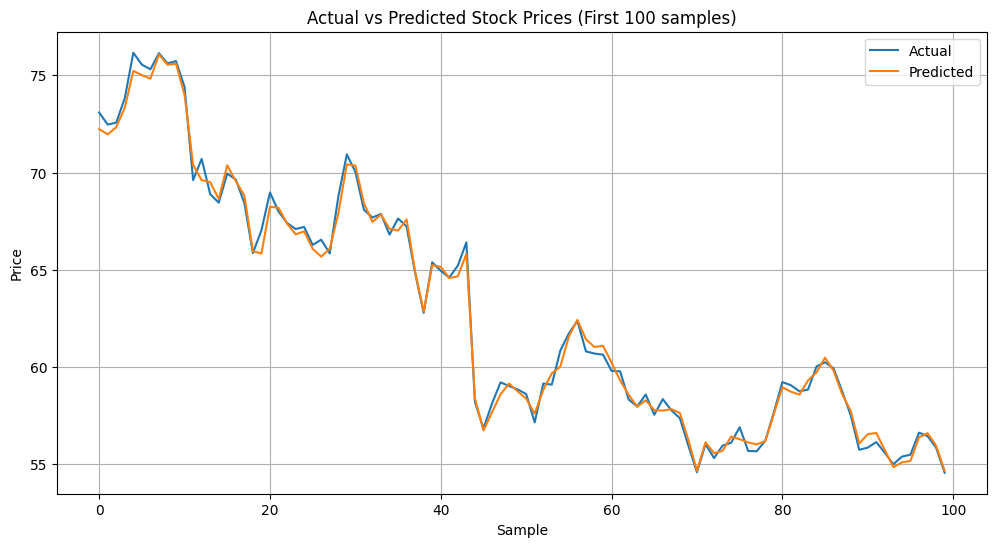

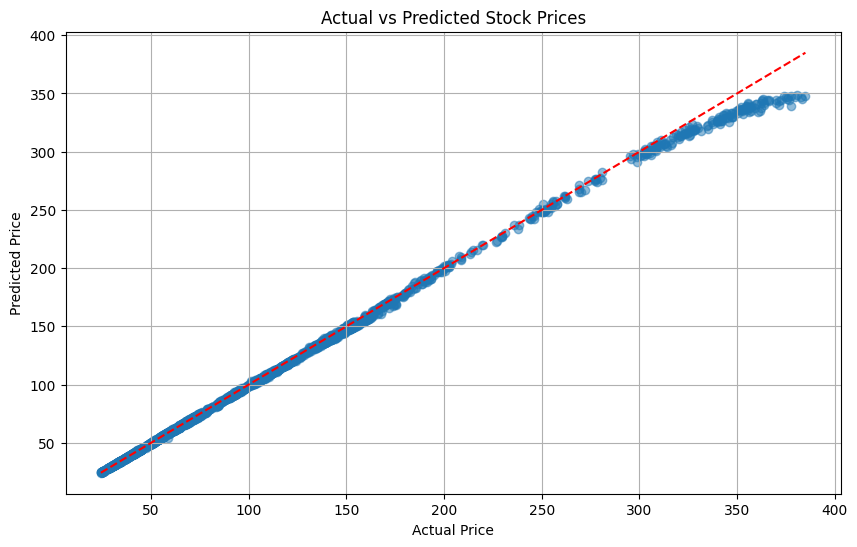

In [14]:
# Plot actual vs predicted values for a subset of the test data
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(y_test_pred[:100], label='Predicted')
plt.title('Actual vs Predicted Stock Prices (First 100 samples)')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.grid(True)
plt.show()

In [15]:
# Create a function to evaluate performance by stock
def evaluate_by_stock(X, y_true, y_pred, df):
    # Get the stock columns
    stock_cols = [col for col in df.columns if col.startswith('Stock_')]
    
    # For each stock, find the indices where it's active
    results = {}
    for col in stock_cols:
        stock_name = col.replace('Stock_', '')
        stock_indices = np.where(df[col] == 1)[0]
        
        if len(stock_indices) > 0:
            stock_y_true = y_true[stock_indices]
            stock_y_pred = y_pred[stock_indices]
            
            mae = mean_absolute_error(stock_y_true, stock_y_pred)
            mse = mean_squared_error(stock_y_true, stock_y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(stock_y_true, stock_y_pred)
            
            results[stock_name] = {
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse,
                'R2': r2,
                'Samples': len(stock_indices)
            }
    
    return results

# Evaluate performance by stock on the test set
test_results_by_stock = evaluate_by_stock(X_test, y_test.values, y_test_pred, test_df)

# Display the results
print("Test Set Performance by Stock:")
for stock, metrics in test_results_by_stock.items():
    print(f"\n{stock}:")
    print(f"  Samples: {metrics['Samples']}")
    print(f"  MAE: {metrics['MAE']:.4f}")
    print(f"  MSE: {metrics['MSE']:.4f}")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  R²: {metrics['R2']:.4f}")

Test Set Performance by Stock:

AAPL:
  Samples: 1255
  MAE: 1.4331
  MSE: 3.6930
  RMSE: 1.9217
  R²: 0.9957

FB:
  Samples: 208
  MAE: 0.8798
  MSE: 1.1566
  RMSE: 1.0755
  R²: 0.9950

MSFT:
  Samples: 1198
  MAE: 0.6110
  MSE: 0.6419
  RMSE: 0.8012
  R²: 0.9967

TSLA:
  Samples: 279
  MAE: 8.3589
  MSE: 148.4739
  RMSE: 12.1850
  R²: 0.9614


Feature Importance:
High: 1.1724
Low: 0.9653
Open: 0.3791
Stock_TSLA: 0.0052
Stock_MSFT: 0.0027
Stock_AAPL: 0.0016
Volume: 0.0006
Month: 0.0004
Stock_FB: 0.0004
Year: 0.0001
Day: 0.0000
DayOfWeek: 0.0000


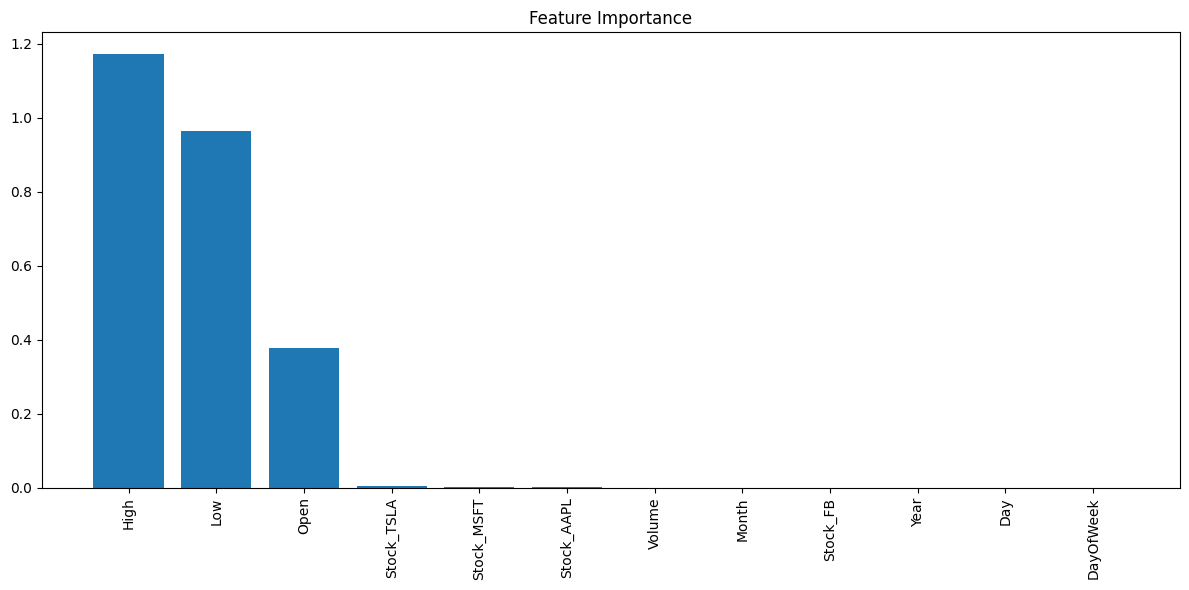

In [16]:
# Since SVR doesn't directly provide feature importance, we'll use permutation importance
from sklearn.inspection import permutation_importance

# Calculate permutation importance
result = permutation_importance(
    best_svr, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# Get feature importance
feature_importance = result.importances_mean
feature_names = features

# Sort features by importance
sorted_idx = feature_importance.argsort()[::-1]

# Display feature importance
print("Feature Importance:")
for idx in sorted_idx:
    print(f"{feature_names[idx]}: {feature_importance[idx]:.4f}")

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importance)), feature_importance[sorted_idx], align='center')
plt.xticks(range(len(feature_importance)), [feature_names[i] for i in sorted_idx], rotation=90)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

Predictions with Uncertainty (First 10 samples) - Fixed Epsilon Tube:
   Actual  Predicted  Lower Bound  Upper Bound
0  73.090  72.238045    72.138045    72.338045
1  72.470  71.964078    71.864078    72.064078
2  72.569  72.338310    72.238310    72.438310
3  73.837  73.343160    73.243160    73.443160
4  76.166  75.233378    75.133378    75.333378
5  75.553  75.011946    74.911946    75.111946
6  75.314  74.828219    74.728219    74.928219
7  76.145  76.083890    75.983890    76.183890
8  75.619  75.548659    75.448659    75.648659
9  75.734  75.598482    75.498482    75.698482


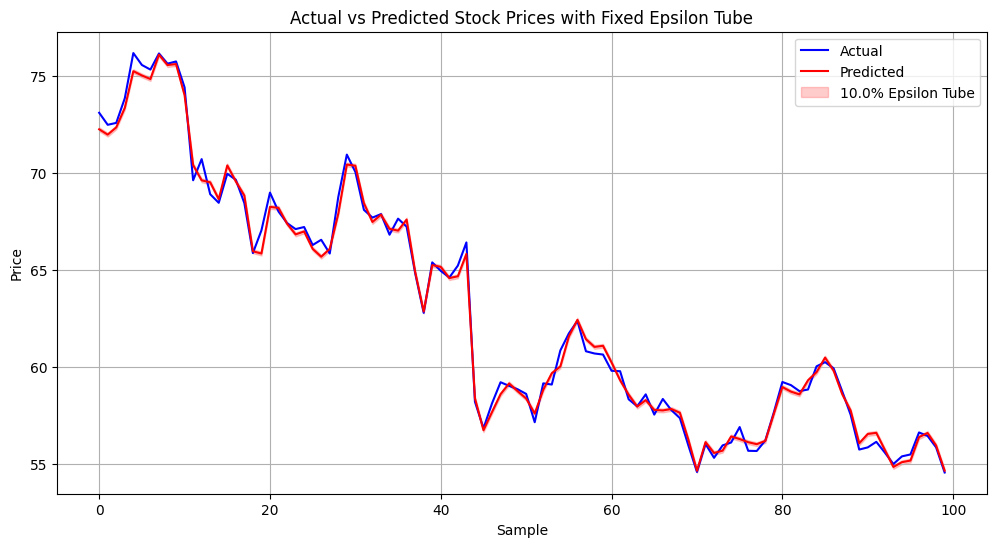

In [17]:
# Get predictions from the SVR model
y_test_pred = best_svr.predict(X_test_scaled)

# The epsilon parameter defines the width of the tube around the regression function
epsilon = best_svr.epsilon

# Create a DataFrame with predictions and fixed-width uncertainty
predictions_df_svr = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred,
    'Lower Bound': y_test_pred - epsilon,
    'Upper Bound': y_test_pred + epsilon
})

# Display the first 10 predictions with uncertainty
print("Predictions with Uncertainty (First 10 samples) - Fixed Epsilon Tube:")
print(predictions_df_svr.head(10))

# Plot predictions with uncertainty intervals
plt.figure(figsize=(12, 6))
plt.plot(predictions_df_svr['Actual'][:100].values, label='Actual', color='blue')
plt.plot(predictions_df_svr['Predicted'][:100].values, label='Predicted', color='red')
plt.fill_between(
    range(100),
    predictions_df_svr['Lower Bound'][:100].values,
    predictions_df_svr['Upper Bound'][:100].values,
    color='red', alpha=0.2, label=f'{epsilon*100:.1f}% Epsilon Tube'
)
plt.title('Actual vs Predicted Stock Prices with Fixed Epsilon Tube')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
import joblib

# Save the model
model_path = '/kaggle/working/svr_stock_prediction_model.pkl'
joblib.dump(best_svr, model_path)
print(f"Model saved to {model_path}")

# Save the scaler
scaler_path = '/kaggle/working/scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

Model saved to /kaggle/working/svr_stock_prediction_model.pkl
Scaler saved to /kaggle/working/scaler.pkl
